In [4]:
from lib.utils import *
from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader
import torch
from torch import nn
from lib.env import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
window_size = 1
foldi = 0
make_cv_data_from_ekyn(foldi,window_size)

data_dir = f'w{window_size}_cv_{foldi}'
trainloader = DataLoader(Dataset2p0(dir=f'{data_dir}/train/',labels=f'{data_dir}/y_train.pt'),batch_size=32,shuffle=True)
devloader = DataLoader(Dataset2p0(dir=f'{data_dir}/dev/',labels=f'{data_dir}/y_dev.pt'),batch_size=32,shuffle=True)
testloader = DataLoader(Dataset2p0(dir=f'{data_dir}/test/',labels=f'{data_dir}/y_test.pt'),batch_size=32,shuffle=True)

dir already exists


In [6]:
from lib.models import MLP
model = MLP().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [23]:
lossi = []
loss_tr = []

model.train()
loss_dev = []

for i in range(2):
    loss_tr_total = 0

    for (X_tr,y_tr) in tqdm(trainloader):
        X_tr,y_tr = X_tr.to(DEVICE),y_tr.to(DEVICE)
        logits = model(X_tr)
        loss = criterion(logits,y_tr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        loss_tr_total += loss.item()
    loss_tr.append(loss_tr_total/len(trainloader))

    with torch.no_grad():
        loss_dev_total = 0
        for (X_dv,y_dv) in devloader:
            X_dv,y_dv = X_dv.to(DEVICE),y_dv.to(DEVICE)
            logits = model(X_dv)
            loss = criterion(logits,y_dv)
            loss_dev_total += loss.item()
        loss_dev.append(loss_dev_total/len(devloader))
# plt.plot(torch.tensor(lossi[:len(lossi) - len(lossi)%10]).view(-1,10).mean(axis=1))
# print(torch.tensor(lossi[:len(lossi) - len(lossi)%10]).view(-1,10).mean(axis=1)[-1])

100%|██████████| 7695/7695 [00:35<00:00, 215.45it/s]


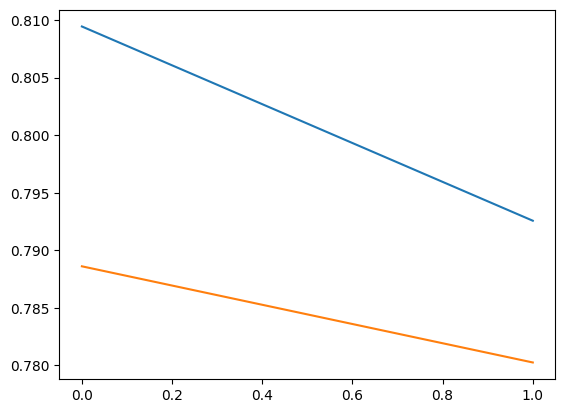

In [26]:
plt.plot(loss_tr)
plt.plot(loss_dev)

In [33]:
from lib.utils import evaluate
loss,metrics,y_true,y_pred,y_logits = evaluate(testloader,model,criterion)
loss

/home/andrew/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.779134287988698

In [ ]:
from lib.utils import *
from lib.utils import cm_grid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd

In [51]:
df = pd.DataFrame()
ids = get_ekyn_ids()
ids.remove('main.ipynb')

In [60]:
clf = UniformRandomClassifier()

for id in ids:
    for condition in ['PF','Vehicle']:
        X,y_true = load_eeg_label_pair(id=id,condition=condition)
        y_true = y_true.argmax(axis=1)
        y_pred = clf.predict(X)
        df = pd.concat([df,pd.DataFrame([id,condition,f1_score(y_true=y_true,y_pred=y_pred,average="macro"),"Uniform"]).T])

In [61]:
clf = ProportionalRandomClassifier()

for id in ids:
    for condition in ['PF','Vehicle']:
        X,y_true = load_eeg_label_pair(id=id,condition=condition)
        y_true = y_true.argmax(axis=1)
        y_pred = clf.predict(X)
        df = pd.concat([df,pd.DataFrame([id,condition,f1_score(y_true=y_true,y_pred=y_pred,average="macro"),"Proportional"]).T])

In [63]:
df[2] = df[2].astype(float)

<AxesSubplot:xlabel='2', ylabel='3'>

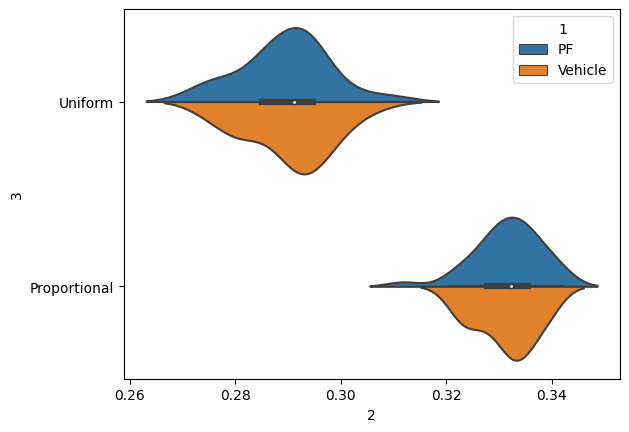

In [64]:
sns.violinplot(data=df,x=2,y=3,hue=1,split=True)

In [ ]:
# leave one out

In [ ]:
ids = get_ekyn_ids()
ids.remove('main.ipynb')
train_id = ids.pop()
X_train,y_train = load_eeg_label_pair(id=train_id,condition='Vehicle')
X_train = torch.vstack([X_train.mean(axis=1),X_train.std(axis=1),X_train.sum(axis=1),(X_train**2).sum(axis=1)]).T
y_train = y_train.argmax(axis=1)
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

In [ ]:
f1s = []
for id in ids:
    X,y_true = load_eeg_label_pair(id=id)
    X = torch.vstack([X.mean(axis=1),X.std(axis=1),X.sum(axis=1),(X**2).sum(axis=1)]).T
    y_true = y_true.argmax(axis=1)
    y_pred = clf.predict(X)
    f1s.append(f1_score(y_true=y_true,y_pred=y_pred,average="macro"))
sns.kdeplot(f1s)
sns.rugplot(f1s)

In [ ]:
print(f'f1 score: {f1_score(y_true=y_true,y_pred=y_pred,average="macro")}')
print(f'precision score: {precision_score(y_true=y_true,y_pred=y_pred,average="macro")}')
print(f'recall score: {recall_score(y_true=y_true,y_pred=y_pred,average="macro")}')
print(f'accuracy: {accuracy_score(y_true=y_true,y_pred=y_pred)}')
cm_grid(y_true=y_true,y_pred=y_pred)